# EDA YOOGLE

En este notebook encontrarás el Análisis exploratorio de datos referente a nuestro proyecto. Para llevar a cabo un análisis de mercado decidimos limitar los Datasets a los Estados de: Nevada, Florida y Virginia.

In [137]:
#Se conecta Google Colaboratory con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
#Se importan las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [139]:
business_yelp= pd.read_parquet("/content/drive/My Drive/YOOGLE/business_yelp.parquet")
metadata_sitios= pd.read_parquet("/content/drive/My Drive/YOOGLE/metadata_sitios.snappy.parquet")
reviews_google= pd.read_parquet("/content/drive/My Drive/YOOGLE/reviews_google.snappy.parquet")
reviews_yelp= pd.read_parquet("/content/drive/My Drive/YOOGLE/reviews_yelp.snappy.parquet")
tips_yelp= pd.read_parquet("/content/drive/My Drive/YOOGLE/tips_yelp.parquet")
users_yelp= pd.read_parquet("/content/drive/My Drive/YOOGLE/users_yelp.parquet")
users_google= pd.read_parquet("/content/drive/My Drive/YOOGLE/users_google.snappy.parquet")



In [140]:
#Esta función calcula el porcentaje de valores nulos que tiene cada columna de un determinado dataframe

def porcentaje_nulos(dataframe):

  longitud=dataframe.shape[0]

  #Cantidad de nulos por columna

  nulos_por_columna = dataframe.isnull().sum()

  #Se hace el cálculo del porcentaje
  porcentaje_nulos= nulos_por_columna.apply(lambda x: round(x*100/longitud,2))

  print("porcentaje de valores nulos por columna:\n", porcentaje_nulos)

# VALORES NULOS

En esta sección analizaremos los valores nulos de cada conjunto de datos, cabe aclarar que estos datasets ya han sido previamente tratados en el ETL y en el EDA preliminar que se encuentra en el repositorio, por lo tanto no es de esperar que los resultados aquí estudiados sean de preocupación.

In [141]:
porcentaje_nulos(business_yelp)

porcentaje de valores nulos por columna:
 business_id       0.0
name              0.0
address           0.0
city              0.0
state             0.0
postal_code       0.0
latitude          0.0
longitude         0.0
stars             0.0
num_of_reviews    0.0
categories        0.0
dtype: float64


In [142]:
porcentaje_nulos(metadata_sitios)

porcentaje de valores nulos por columna:
 address              0.00
avg_rating           0.00
category             0.00
gmap_id              0.00
latitude             0.00
longitude            0.00
name                 0.00
num_of_reviews       0.00
relative_results    22.53
state                0.00
city                 0.00
dtype: float64


In [143]:
porcentaje_nulos(reviews_google)

porcentaje de valores nulos por columna:
 gmap_id       0.00
rating        0.00
text         38.85
user_id       0.00
state         0.00
year          0.00
month         0.00
day           0.00
sentiment     0.00
dtype: float64


In [144]:
porcentaje_nulos(reviews_yelp)

porcentaje de valores nulos por columna:
 review_id      0.0
business_id    0.0
user_id        0.0
rating         0.0
year           0.0
month          0.0
day            0.0
text           0.0
sentiment      0.0
dtype: float64


In [145]:
porcentaje_nulos(users_google)

porcentaje de valores nulos por columna:
 user_id    0.0
name       0.0
dtype: float64


In [146]:
porcentaje_nulos(users_yelp)

porcentaje de valores nulos por columna:
 user_id    0.0
name       0.0
dtype: float64


In [147]:
porcentaje_nulos(tips_yelp)

porcentaje de valores nulos por columna:
 user_id        0.0
business_id    0.0
text           0.0
year           0.0
month          0.0
day            0.0
dtype: float64


Como se pudo observar los datos faltan se atribuyen a reseñas sin texto y a negocios que no tienen resultados relacionados. Sin embargo de las reseñas sin texto podemos extraer el rating que califica el lugar y en base a eso se realiza el análisis de sentimientos; con respecto a los resultados relacionados es un plus que nos ayudará a comparar negocios en el sistema de recomendación, pero no es indispensable.

#OUTLIERS

Vamos a estudiar el intervalo de tiempo en el que transcurren las reseñas para ver si ocurre alguna inconsistencia.

In [148]:
# Encuentra el valor máximo y mínimo de 'year'
valor_maximo = reviews_google['year'].max()
valor_minimo = reviews_google['year'].min()

print(f'El último año es: {valor_maximo}')
print(f'El primer año es: {valor_minimo}')

El último año es: 2021
El primer año es: 1990


Hay reseñas desde 1990 hasta 2021 por parte de Google Maps, esto no puede ocurrir porque Google Maps existe desde 2005. Estos datos desde 1990 hasta 2005 ya se catalogan como resultados inesperados.

In [149]:
reviews_google[reviews_google["year"]==1990]

,gmap_id,rating,text,user_id,state,year,month,day,sentiment
1366481,0x89b64af46a576a43:0x31cd60d2502b5cf5,4,"Great service. Food is good for a chain, but o...",118122900081499203361,VA,1990,12,31,2


In [150]:
#Transformo reviews_google para tomar todas las reseñas que se hacen desde 2005

reviews_google=reviews_google[reviews_google["year"]>=2005]

In [151]:
# Encontrar el valor máximo y mínimo de 'year'
valor_maximo = reviews_yelp['year'].max()
valor_minimo = reviews_yelp['year'].min()

print(f'El último año es: {valor_maximo}')
print(f'El primer año es: {valor_minimo}')

El último año es: 2022
El primer año es: 2005


Teniendo en cuenta que Yelp existe desde 2004, este dataset si es coherente con la información temporal que presenta.

Nuestros restaurantes pueden pertenecer a diferentes categorías, las cuales pueden ser muy variadas, hagamos un conteo del total de categorías que se encuentran en los datos.

In [152]:
# Crea una lista de todas las categorías de business_yelp
categories_yelp = business_yelp['categories'].str.split(',').explode().str.strip().unique()

# Crea una lista de todas las categorías de metadata_sitios
categories_metadata = metadata_sitios['category'].str.split(',').explode().str.strip().unique()

# Une ambas listas y obtiene las categorías únicas
all_categories = pd.Series(list(categories_yelp) + list(categories_metadata)).unique()

print(f"Hay {len(all_categories)} categorías")

Hay 1331 categorías


Ahora vamos a encontrar las ciudades con mayor número de restaurantes, esto nos permitirá delimitar el análisis de mercado a las principales ciudades y zonas comerciales.

In [153]:
# Cuenta el número de negocios por ciudad en business_yelp
city_counts_yelp = business_yelp['city'].str.strip().value_counts()

# Cuenta el número de negocios por ciudad en metadata_sitios
city_counts_metadata = metadata_sitios['city'].str.strip().value_counts()

# Suma el número de negocios por ciudad de ambos DataFrames
combined_city_counts = city_counts_yelp.add(city_counts_metadata, fill_value=0)

# Obtiene las 10 ciudades con más negocios y las ordena
top_10_cities = combined_city_counts.sort_values(ascending=False).head(10)

# Imprime el resultado
print("Las 10 ciudades con más restaurantes son:")
print(top_10_cities)

Las 10 ciudades con más restaurantes son:
Tampa           1339.0
Philadelphia    1305.0
Miami           1204.0
Las Vegas       1187.0
Orlando          815.0
Indianapolis     652.0
Nashville        573.0
Tucson           566.0
Jacksonville     535.0
New Orleans      521.0
Name: city, dtype: float64


Aquí nos chocamos con incongruencias en los datos, en el top 2 se encuentra la ciudad de Philadelphia, que como se verá a continuación a veces la ubica en el Estado de Florida y a veces en el Estado de Nevada; sin embargo en la realidad pertenece al Estado de Pensilvania.

Teniendo esto presente decidimos elegir para nuestro análisis de mercado las tres ciudades que si pertenecen a los estados que habiamos predefinido: Tampa, Miami Y Las Vegas. Siendo dos ciudades de Florida y una de Nevada en las que centraremos nuestra atención para iniciar el plan de expansión de nuestro cliente.

In [154]:
#Imprimo los primeros 5 restaurantes que se encuentran en Philadelphia

business_yelp[business_yelp['city']=='Philadelphia'].head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,num_of_reviews,categories
5,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,Philadelphia,FL,19104,39.954573,-75.194894,3.0,56,"Restaurants, Automotive, Delis, Gas Stations, ..."
16,n8ecak12IF_jhnPNs37AZA,Baltic Bakery,2609 Edgemont St,Philadelphia,FL,19125,39.976880,-75.116169,4.5,12,"Food, Bakeries, Restaurants"
24,GVqXNt0HKJLpciN9ePxnWw,Crown Fried Chicken,1128 S Broad St,Philadelphia,FL,19146,39.936891,-75.167284,2.5,16,"Restaurants, Fast Food"
46,yFqq66GxRjnhZXPgjA6hnw,KFC,716 Adams Ave,Philadelphia,NV,19124,40.031578,-75.104787,2.0,7,"Restaurants, Chicken Shop, Fast Food, Chicken ..."
47,kLSEk3qXY1KdtFjxHJ9pww,McDonald's,501 Franklin Mill Cir,Philadelphia,FL,19154,40.088416,-74.965011,1.5,20,"Restaurants, Fast Food, Food, Coffee & Tea, Bu..."


También es interesante conocer qué categorías de restaurantes tienen más negocio dentro de los tres Estados.

In [155]:
# Concatenar las columnas 'categories' de ambos DataFrames
all_categories_series = pd.concat([metadata_sitios['category'], business_yelp['categories']], ignore_index=True)

# Dividir las listas de categorías y convertirlas en una Serie
all_categories_series = all_categories_series.str.split(',').explode().str.strip()

# Contar la frecuencia de cada categoría
category_counts = all_categories_series.value_counts()

# Obtener el top 5 de categorías más comunes
top_10_categories = category_counts.head(10)

# Imprimir el resultado
print("Top 10 categorías más comunes:")
print(top_10_categories)

Top 10 categorías más comunes:
Restaurants             11881
Restaurant               9746
Food                     3535
Fast food restaurant     2624
Takeout Restaurant       2070
Pizza restaurant         2038
Nightlife                1938
Sandwiches               1894
Bars                     1869
Sandwich shop            1842
dtype: int64


En este caso nos quedamos con las cinco categorías que no son 'obvias': Fast food restaurant, Takeout Restaurant, Pizza restaurant, Nightlife, Sandwiches.

Queda por ver cuántos de los restaurantes son vegetarianos o veganos, para saber si tenemos suficientes datos.

In [156]:
# Filtra las filas que contienen 'Vegetarian' o 'Vegan' en la columna 'category'
vegetarian_google = metadata_sitios[metadata_sitios['category'].str.contains('Vegetarian|Vegan', case=False)]

# Imprime el resultado
print(vegetarian_google.shape[0])

462


In [157]:
# Filtra las filas que contienen 'Vegetarian' o 'Vegan' en la columna 'categories'
vegetarian_yelp = business_yelp[business_yelp['categories'].str.contains('Vegetarian|Vegan', case=False)]

# Imprime el resultado
print(vegetarian_yelp.shape[0])

381


Son datos suficientes para analizar competidores directos en el análisis de mercado. Sin embargo debemos extrar reseñas de nuestro cliente directamente de la API de Google Maps para llevar un control de los KPI.

Es importante explorar el rango que tiene el número de reseñas, esto con la finalidad de descartar posibles outlier. Como se verá a continuación el restaurante con más reseñas tiene 7671 lo cual es totalmente posible.

In [158]:
# Encuentra el valor máximo y mínimo de 'num_of_reviews'
valor_maximo = metadata_sitios['num_of_reviews'].max()
valor_minimo = metadata_sitios['num_of_reviews'].min()

print(f'El mayor número de reseñas en google es: {valor_maximo}')
print(f'El menor número de reseñas en google es: {valor_minimo}')

El mayor número de reseñas en google es: 7671
El menor número de reseñas en google es: 1


In [159]:
# Encuentra el valor máximo y mínimo de 'num_of_reviews'
valor_maximo = business_yelp['num_of_reviews'].max()
valor_minimo = business_yelp['num_of_reviews'].min()

print(f'El mayor número de reseñas en yelp es: {valor_maximo}')
print(f'El menor número de reseñas en yelp es: {valor_minimo}')

El mayor número de reseñas en yelp es: 7400
El menor número de reseñas en yelp es: 5


# ANÁLISIS GRÁFICO

Ahora vamos a tratar de visualizar tendencias y a interpretar gráficos, empezamos con dos histogramas que nos representan el progreso temporal que tuvieron las reseñas a través de los años en cada plataforma.

In [160]:
#Creo una lista de los años en los que se hacen reseñas
all_years=[2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]

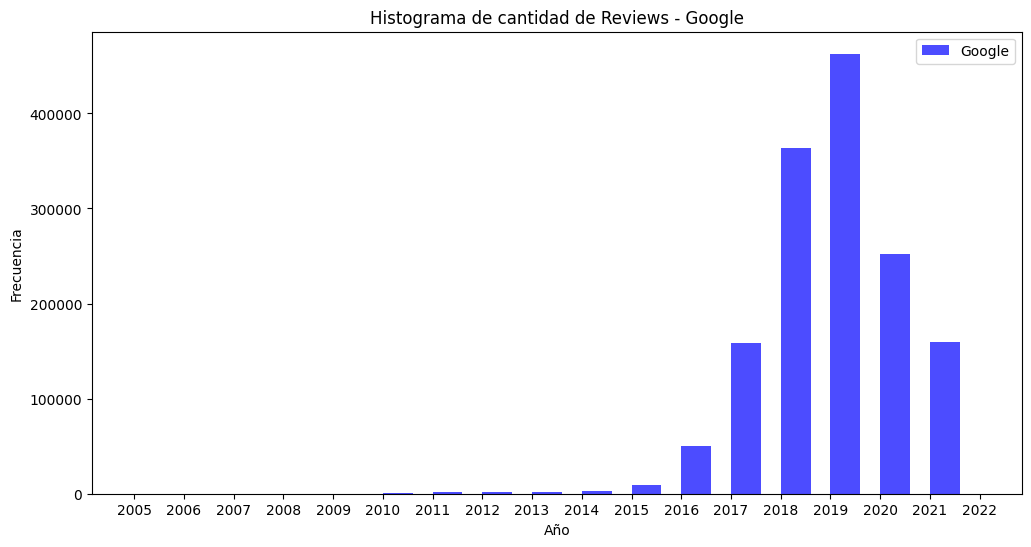

In [161]:
# Histograma para Google
plt.figure(figsize=(12, 6))
plt.hist(reviews_google['year'], bins=all_years, color='blue', alpha=0.7, label='Google',width=0.6, align='mid')
plt.xlabel('Año')
plt.xticks(np.arange(min(all_years), max(all_years) + 1, 1),fontsize=10)
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de Reviews - Google')
plt.legend()
plt.show()

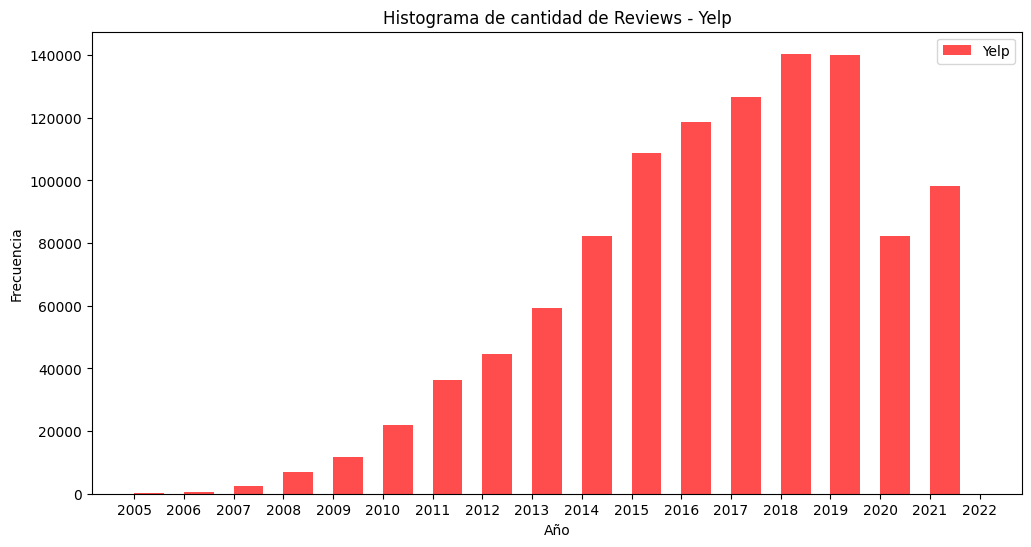

In [162]:
# Histograma para Yelp
plt.figure(figsize=(12, 6))
plt.hist(reviews_yelp['year'], bins=all_years, color='red', alpha=0.7, label='Yelp',width=0.6, align='mid')
plt.xlabel('Año')
plt.xticks(np.arange(min(all_years), max(all_years) + 1, 1),fontsize=10)
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de Reviews - Yelp')
plt.legend()
plt.show()

Como se puede observar hay un fuerte crecimiento en las reseñas, entre los años 2015 y 2019; desde el 2020 hay una tendencia a la baja debido a la pandemia y las consecuencias de la cuarentena preventiva.

In [163]:
# Elimino los espacios laterales de las cadenas de texto en la columna 'city'
business_yelp['city'] = business_yelp['city'].str.strip()

metadata_sitios['city'] = metadata_sitios['city'].str.strip()

Como dije anteriormente, es mejor enfocarnos en las tres ciudades con mayor número de restaurante, ya que esto indica una economía dinámica y zonas comerciales atractivas. Esto ya entra en una etapa de 'pre-análisis de mercado', donde veremos que con los datos que tenemos podemos detectar patrones interesantes.

A continuación se realizarán mapas de calor de la presencia de restaurantes en las tres ciudades elegidas: Miami, Tampa y Las Vegas.

In [164]:
#Muestro cuantos restaurantes de Miami hay en el Dataset business_yelp

business_yelp[business_yelp['city']=='Miami'].head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,num_of_reviews,categories


In [165]:
#Muestro cuantos restaurantes de Miami hay en el Dataset metadata_sitios

metadata_sitios[metadata_sitios['city']=='Miami'].head(5)

,address,avg_rating,category,gmap_id,latitude,longitude,name,num_of_reviews,relative_results,state,city
12,"Choices Cafe, 711 NW 27th Ave",4.6,Restaurant,0x88d9b719170a9f61:0x30d454a980f76ad3,25.779837,-80.239103,Choices Cafe,45,"[0x88d9b486489d7f3f:0x3e02d9f17e126101, 0x88d9...",FL,Miami
18,"Biscayne Backyard Barbecue, 11064 Biscayne Blvd",3.9,Restaurant,0x88d9b395c6179c89:0x914b0aafb453b3b5,25.877904,-80.168434,Biscayne Backyard Barbecue,23,None,FL,Miami
21,"Crab Du Jour Cajun Seafood & Bar, 3201 N Miam...",4.7,"Seafood restaurant, Bar, Cajun restaurant, Chi...",0x88d9b1f38dff4dff:0x61443de98cd9c88c,25.807920,-80.194382,Crab Du Jour Cajun Seafood & Bar,88,None,FL,Miami
28,"Pizza cubana& Italiana Dileo's House LLC, 730...",4.9,Pizza restaurant,0x88d9b714af842939:0xbc6dc5c9cb27536e,25.769772,-80.313921,Pizza cubana& Italiana Dileo's House LLC,38,"[0x88d9b846a5d55897:0xfc623bf8c2e20ca7, 0x88d9...",FL,Miami
67,"Palma Juice Co., 8300 NE 2nd Ave",4.4,"Juice shop, Health food restaurant",0x88d9b1005bc3752d:0xb173e4bc55c800f1,25.851944,-80.193245,Palma Juice Co.,8,"[0x88d9b3d4f27cb327:0xd92533e82b8b689, 0x88d9b...",FL,Miami


In [166]:
#Creo un dataframe para Miami

Miami_sitios=metadata_sitios[metadata_sitios['city']=='Miami']

In [167]:
# Crea un mapa interactivo centrado en Miami con la librería folium
miami_map = folium.Map(location=[25.7617, -80.1918], zoom_start=11, control_scale=True)

# Crea un mapa de calor y lo agrega al mapa de Miami
heat_data = [[point.latitude, point.longitude] for point in Miami_sitios.itertuples()]
HeatMap(heat_data).add_to(miami_map)

#Visualiza el mapa
miami_map

Aquí se puede ver que nuestros datos son bastante coherentes, la zona más caliente es la que está más cerca de Miami Beach y las zonas más turísticas.

Repetimos el proceso para Tampa y para Las Vegas.

In [168]:
business_yelp[business_yelp['city']=='Tampa'].head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,num_of_reviews,categories
9,QjV4v7q_pt7tt3K1US7IHg,PDQ Temple Terrace,5112 E Fowler Ave,Tampa,FL,33617,28.054888,-82.399548,3.0,5,"Fast Food, Sandwiches, Chicken Shop, Restaurants"
27,sUQ-OfJYSNfz-cimEjoaXQ,Soho Oasis Cafe,410 S Howard Ave,Tampa,FL,33606,27.940206,-82.482884,3.5,7,"Restaurants, Middle Eastern"
28,z9wCTHYI2VZy9YIblwSsgg,The Silo Eatery Coffee Bakery,"9036 Brittany Way, Bldg 18",Tampa,FL,33619,27.946496,-82.355563,4.0,5,"Coffee & Tea, Restaurants, Food, Cafes, Bakeries"
35,dIpTuL2T1L98GQGU17IeSw,The Bricks,1327 E 7th Ave,Tampa,NV,33605,27.960024,-82.444401,4.0,548,"Bars, Breakfast & Brunch, Restaurants, America..."
37,FW1PXpUq-yOs-5O_gqz3AQ,Big Mike's BBQ,6901 Sheldon Rd,Tampa,NV,33615,28.011500,-82.582840,4.5,32,"Restaurants, Barbeque"


In [169]:
metadata_sitios[metadata_sitios['city']=='Tampa'].head(5)

,address,avg_rating,category,gmap_id,latitude,longitude,name,num_of_reviews,relative_results,state,city
23,"Flock and Stock, 615 Channelside Dr",2.8,Restaurant,0x88c2c5c515fa6e53:0xee4f630ca314fe01,27.943383,-82.447510,Flock and Stock,52,[0x88c2c5056de83ac1:0x620ac50153c61f98],FL,Tampa
116,"Flock and Stock, 615 Channelside Dr",2.8,Restaurant,0x88c2c5c515fa6e53:0xee4f630ca314fe01,27.943383,-82.447510,Flock and Stock,52,[0x88c2c5056de83ac1:0x620ac50153c61f98],FL,Tampa
288,"D'Alessio Pizza & Pastries, 14831 N Florida Ave",5.0,Restaurant,0x88c2c75b830ec3fb:0x7ef881d17cd34808,28.083660,-82.459118,D'Alessio Pizza & Pastries,3,"[0x88c2c37668665b27:0x3c52ed3ffa3a1fc4, 0x88c2...",FL,Tampa
290,"Lenny's Sub Shop, 5701 W Waters Ave",1.0,"American restaurant, Box lunch supplier, Cater...",0x88c2c1ea8f4404f9:0xc7ebf2a550f8869d,28.026061,-82.542637,Lenny's Sub Shop,1,None,FL,Tampa
291,"Bennigan's, 615 Channelside Dr #5942",2.0,Restaurant,0x88c2c4f199418f8f:0x610540c2747e67a6,27.943199,-82.446677,Bennigan's,1,"[0x88c2c346304dafd9:0xb0764bb9394a6267, 0x88c2...",FL,Tampa


In [170]:
metadata_sitios_tampa=metadata_sitios[metadata_sitios['city']=='Tampa'][['longitude','latitude']]
business_yelp_tampa=business_yelp[business_yelp['city']=='Tampa'][['longitude','latitude']]

Tampa_sitios = pd.concat([metadata_sitios_tampa, business_yelp_tampa], ignore_index=True).drop_duplicates()

In [171]:

# Crea un mapa centrado en Tampa
tampa_map = folium.Map(location=[27.9506, -82.4572], zoom_start=11)  # Coordenadas aproximadas del centro de Tampa

# Crea un mapa de calor
heat_data = Tampa_sitios[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data).add_to(tampa_map)

tampa_map

In [172]:
business_yelp[business_yelp['city']=='Las Vegas']

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,num_of_reviews,categories


In [173]:
metadata_sitios[metadata_sitios['city']=='Las Vegas'].head(5)

,address,avg_rating,category,gmap_id,latitude,longitude,name,num_of_reviews,relative_results,state,city
16,"El Yaqui Mexican Food & Desserts, 5120 W Char...",4.9,Restaurant,0x80c8c10f727e3ae1:0x9085c8978a7b1813,36.159371,-115.211149,El Yaqui Mexican Food & Desserts,15,None,NV,Las Vegas
30,"El chiringuito mexican snacks., 4907 Vegas Dr...",4.8,Restaurant,0x80c8c1186114520b:0x181d6e75c4cd85ed,36.187988,-115.207601,El chiringuito mexican snacks.,18,None,NV,Las Vegas
35,"Geyland Claypot Rice, 3000 S Las Vegas Blvd",1.8,Singaporean restaurant,0x80c8c546ee1c5d7d:0xd99073e590b4dea7,36.134783,-115.165538,Geyland Claypot Rice,5,None,NV,Las Vegas
58,"Domino's Pizza, 6540 E Lake Mead Blvd",3.7,"Pizza delivery, Delivery Restaurant, Takeout R...",0x80c8dd7678249c49:0x6f2556114030dded,36.196051,-115.030257,Domino's Pizza,8,None,NV,Las Vegas
61,"Carmines Little Italy Instant, 5570 W Flaming...",5.0,Italian restaurant,0x80c8c6c19d4096eb:0x49c4f8ca0fdfd052,36.115355,-115.217713,Carmines Little Italy Instant,1,"[0x80c8c15614e1be9b:0x5ce10cb0928d4b96, 0x80c8...",NV,Las Vegas


In [174]:
Vegas_sitios=metadata_sitios[metadata_sitios['city']=='Las Vegas']

In [175]:

# Crea un mapa centrado en Las Vegas
vegas_map = folium.Map(location=[36.1699, -115.1398], zoom_start=11)  # Coordenadas aproximadas del centro de Las Vegas

# Crea un mapa de calor
heat_data_vegas = Vegas_sitios[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data_vegas).add_to(vegas_map)

vegas_map

Por último queda ver si tenemos información suficiente para enfocarnos en nuestro nicho referente a la gastronomía vegetariana y/o vegana. Ya vimos que si tenemos una gran cantidad de restaurante, queda por ver las reseñas, para esto decidimos hacer dos histogramas parecidos a los que se hicieron anteriormente pero enfocándonos únicamente en restaurantes de la especialidad.

In [176]:
#Crea listas de id de negocios vegetarianos en las dos plataformas
lista_vegetarianos_google=vegetarian_google['gmap_id'].tolist()
lista_vegetarianos_yelp=vegetarian_yelp['business_id'].tolist()

In [177]:
#Filtra las reviews que pertenecen a alguno de los restaurantes enlistados
reviews_vegetarianas_google = reviews_google[reviews_google['gmap_id'].isin(lista_vegetarianos_google)]
reviews_vegetarianas_yelp = reviews_yelp[reviews_yelp['business_id'].isin(lista_vegetarianos_yelp)]

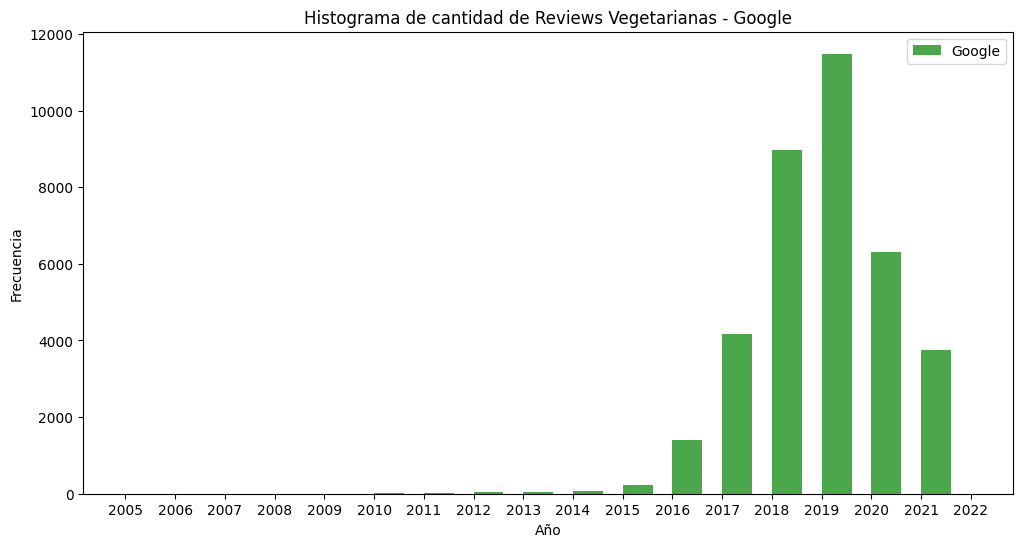

In [178]:
# Histograma para restaurantes vegetarianos en Google Maps
plt.figure(figsize=(12, 6))
plt.hist(reviews_vegetarianas_google['year'], bins=all_years, color='green', alpha=0.7, label='Google',width=0.6, align='mid')
plt.xlabel('Año')
plt.xticks(np.arange(min(all_years), max(all_years) + 1, 1),fontsize=10)
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de Reviews Vegetarianas - Google')
plt.legend()
plt.show()

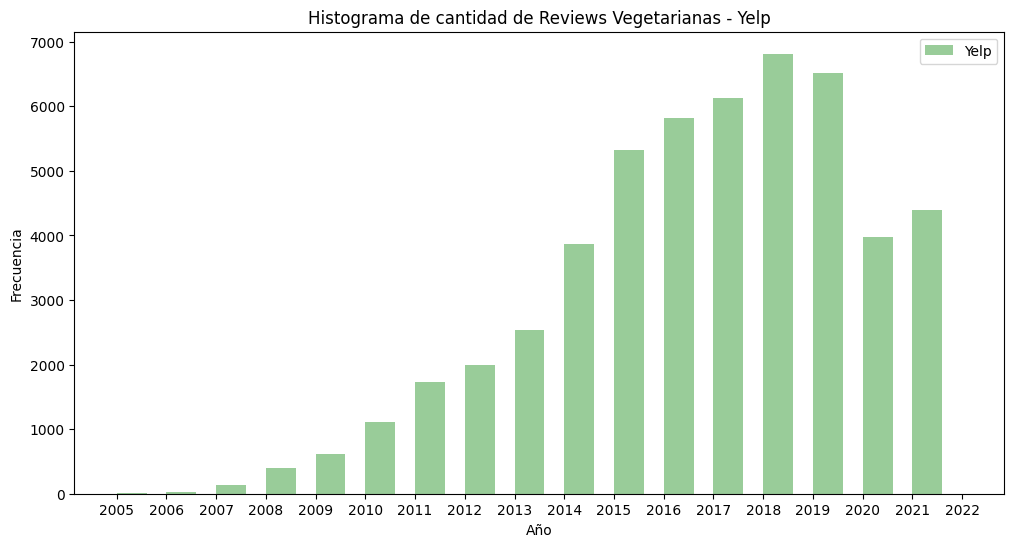

In [179]:
# Histograma para restaurantes vegetarianos en Yelp
plt.figure(figsize=(12, 6))
plt.hist(reviews_vegetarianas_yelp['year'], bins=all_years, color='green', alpha=0.4, label='Yelp',width=0.6, align='mid')
plt.xlabel('Año')
plt.xticks(np.arange(min(all_years), max(all_years) + 1, 1),fontsize=10)
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de Reviews Vegetarianas - Yelp')
plt.legend()
plt.show()

Se aprecian tendencias similares a las de los restaurantes en general, esto indica que el consumo de la comida vegetariana incrementa y representa un gran nicho para invertir.

Los tips nos serán de utilidad para aprender de los errores de otros restaurantes y realizar estrategias más efectivas. Para esto debemos encontrar los tips que se hacen a los restaurantes vegetarianos o veganos y tener conocimiento de cuántos tenemos para un futuro análisis.

In [180]:
tips_vegetarianos = tips_yelp[tips_yelp['business_id'].isin(lista_vegetarianos_yelp)]

In [181]:
print(f"El número de tips a restaurantes vegetarianos es: {tips_vegetarianos.shape[0]}")

El número de tips a restaurantes vegetarianos es: 7154
